# LSTM Model for Network Intrusion Detection

This notebook implements and evaluates a Bidirectional LSTM model for binary classification on the NSL-KDD dataset.

**Model Overview:**
- Bidirectional LSTM (3 layers, 256 hidden units)
- Binary classification: Normal vs Attack
- Test Accuracy: **80.78%**

**Author:** LSTM Implementation for NIDS-DL Project

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, roc_curve, auc, precision_recall_curve
)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("Setup complete!")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Setup complete!


## 2. Load NSL-KDD Dataset

In [2]:
# Column names for NSL-KDD
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Binary classification mapping
ATTACK_MAPPING = {
    'normal': 0,
    'back': 1, 'land': 1, 'neptune': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 1, 'nmap': 1, 'portsweep': 1, 'satan': 1, 'mscan': 1, 'saint': 1,
    'ftp_write': 1, 'guess_passwd': 1, 'imap': 1, 'multihop': 1, 'phf': 1,
    'spy': 1, 'warezclient': 1, 'warezmaster': 1, 'sendmail': 1, 'named': 1,
    'snmpgetattack': 1, 'snmpguess': 1, 'xlock': 1, 'xsnoop': 1, 'worm': 1,
    'buffer_overflow': 1, 'loadmodule': 1, 'perl': 1, 'rootkit': 1,
    'httptunnel': 1, 'ps': 1, 'sqlattack': 1, 'xterm': 1,
}

# Load data
DATA_PATH = Path('../../data/raw/nsl-kdd/')
train_df = pd.read_csv(DATA_PATH / 'train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv(DATA_PATH / 'test.txt', header=None, names=COLUMNS)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Training samples: 125,973
Test samples: 22,544


## 3. Data Preprocessing

In [3]:
def preprocess_data(train_df, test_df):
    """Preprocess NSL-KDD data for LSTM model."""
    # Remove difficulty level
    train_df = train_df.drop('difficulty_level', axis=1)
    test_df = test_df.drop('difficulty_level', axis=1)
    
    # Map labels to binary
    train_df['label'] = train_df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    test_df['label'] = test_df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    
    # Separate features and labels
    X_train = train_df.drop('label', axis=1)
    y_train = train_df['label'].values
    X_test = test_df.drop('label', axis=1)
    y_test = test_df['label'].values
    
    # Encode categorical features
    cat_cols = ['protocol_type', 'service', 'flag']
    label_encoders = {}
    
    for col in cat_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        # Handle unseen labels in test set
        X_test[col] = X_test[col].apply(lambda x: x if x in le.classes_ else 'unknown')
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.values.astype(np.float32))
    X_test = scaler.transform(X_test.values.astype(np.float32))
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler = preprocess_data(train_df.copy(), test_df.copy())

# Create validation split
val_size = int(0.1 * len(X_train))
indices = np.random.permutation(len(X_train))
X_val, y_val = X_train[indices[:val_size]], y_train[indices[:val_size]]
X_train, y_train = X_train[indices[val_size:]], y_train[indices[val_size:]]

print(f"\nDataset shapes:")
print(f"  Training:   {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test:       {X_test.shape}")
print(f"\nClass distribution (Train): Normal={sum(y_train==0):,}, Attack={sum(y_train==1):,}")
print(f"Class distribution (Test):  Normal={sum(y_test==0):,}, Attack={sum(y_test==1):,}")


Dataset shapes:
  Training:   (113376, 41)
  Validation: (12597, 41)
  Test:       (22544, 41)

Class distribution (Train): Normal=60,555, Attack=52,821
Class distribution (Test):  Normal=9,711, Attack=12,833


## 4. LSTM Model Architecture

In [4]:
class ImprovedLSTMClassifier(nn.Module):
    """
    Bidirectional LSTM for Network Intrusion Detection.
    
    Architecture:
    - Input BatchNorm + Linear embedding
    - 3-layer Bidirectional LSTM (256 hidden units)
    - Classification head with BatchNorm and Dropout
    """
    
    def __init__(self, input_dim, num_classes=2, hidden_dim=256, 
                 num_layers=3, dropout=0.4, bidirectional=True):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        # Feature embedding
        self.input_bn = nn.BatchNorm1d(input_dim)
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_dim * self.num_directions),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * self.num_directions, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = self.input_bn(x)
        x = torch.relu(self.input_fc(x))
        x = x.unsqueeze(1)  # (batch, 1, features)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        return self.classifier(x)

# Create model
model = ImprovedLSTMClassifier(
    input_dim=X_train.shape[1],
    num_classes=2,
    hidden_dim=256,
    num_layers=3,
    dropout=0.4,
    bidirectional=True
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: ImprovedLSTMClassifier")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"\nArchitecture:")
print(model)

Model: ImprovedLSTMClassifier
Total parameters: 4,292,756
Trainable parameters: 4,292,756

Architecture:
ImprovedLSTMClassifier(
  (input_bn): BatchNorm1d(41, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (input_fc): Linear(in_features=41, out_features=256, bias=True)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
  (classifier): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)


## 5. Training Configuration

In [5]:
# Hyperparameters
CONFIG = {
    'batch_size': 512,
    'epochs': 100,
    'learning_rate': 0.0005,
    'weight_decay': 1e-4,
    'patience': 20,
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train), torch.LongTensor(y_train)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_val), torch.LongTensor(y_val)
)
test_dataset = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_test), torch.LongTensor(y_test)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=CONFIG['batch_size'], shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=CONFIG['batch_size'], shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=CONFIG['batch_size'], shuffle=False
)

# Class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weights = torch.FloatTensor(len(y_train) / (2 * class_counts)).to(device)
print(f"\nClass weights: {class_weights.cpu().numpy()}")

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

Training Configuration:
  batch_size: 512
  epochs: 100
  learning_rate: 0.0005
  weight_decay: 0.0001
  patience: 20

Class weights: [0.9361407 1.0732095]


## 6. Training Loop

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_batch.size(0)
        correct += predicted.eq(y_batch).sum().item()
    
    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return total_loss / len(loader), correct / total, all_preds, all_labels, all_probs

In [7]:
# Training
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
patience_counter = 0

print(f"Training for {CONFIG['epochs']} epochs...\n")

for epoch in range(CONFIG['epochs']):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), '../../results/models/lstm_notebook_best.pt')
        marker = " ★ Best!"
    else:
        patience_counter += 1
        marker = ""
    
    if (epoch + 1) % 10 == 0 or marker:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Train: {train_acc*100:.2f}% | Val: {val_acc*100:.2f}%{marker}")
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\nBest validation accuracy: {best_val_acc*100:.2f}%")

Training for 100 epochs...

Epoch   1/100 | Train: 97.53% | Val: 98.42% ★ Best!
Epoch   2/100 | Train: 98.80% | Val: 98.99% ★ Best!
Epoch   5/100 | Train: 99.15% | Val: 99.10% ★ Best!
Epoch   6/100 | Train: 99.25% | Val: 99.30% ★ Best!
Epoch   9/100 | Train: 99.37% | Val: 99.40% ★ Best!
Epoch  10/100 | Train: 99.40% | Val: 99.33%
Epoch  13/100 | Train: 99.43% | Val: 99.44% ★ Best!
Epoch  19/100 | Train: 99.48% | Val: 99.50% ★ Best!
Epoch  20/100 | Train: 99.48% | Val: 99.52% ★ Best!
Epoch  28/100 | Train: 99.59% | Val: 99.53% ★ Best!
Epoch  30/100 | Train: 99.62% | Val: 99.49%
Epoch  38/100 | Train: 99.64% | Val: 99.56% ★ Best!
Epoch  40/100 | Train: 99.65% | Val: 99.54%
Epoch  43/100 | Train: 99.66% | Val: 99.57% ★ Best!
Epoch  44/100 | Train: 99.65% | Val: 99.62% ★ Best!
Epoch  50/100 | Train: 99.67% | Val: 99.58%
Epoch  60/100 | Train: 99.72% | Val: 99.58%

Early stopping at epoch 64

Best validation accuracy: 99.62%


## 7. Training History Visualization

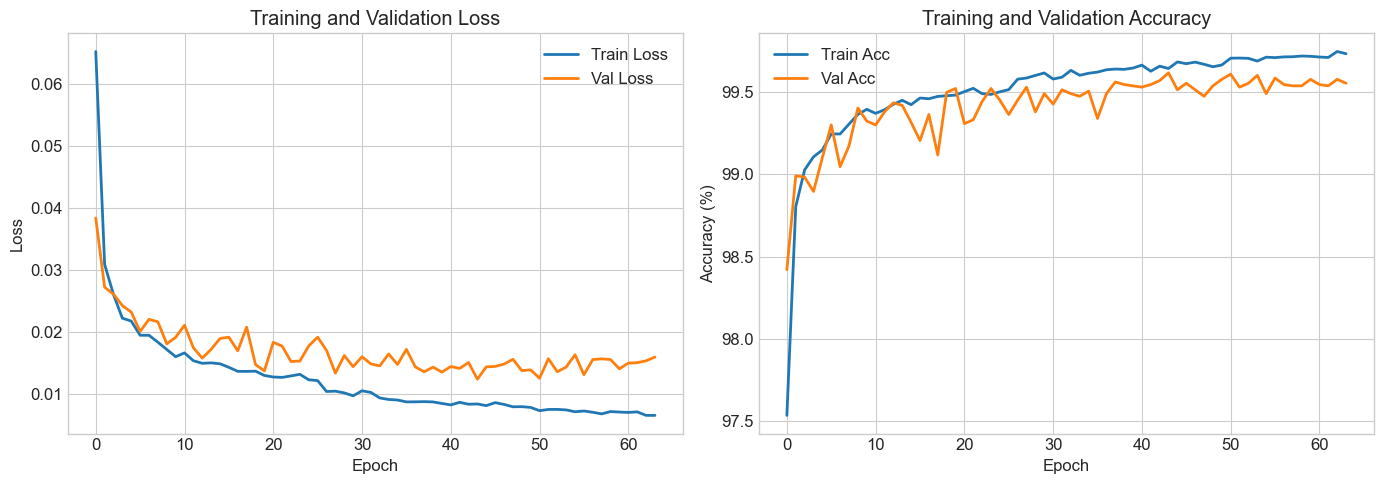

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot([x*100 for x in history['train_acc']], label='Train Acc', linewidth=2)
axes[1].plot([x*100 for x in history['val_acc']], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../../results/figures/lstm_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Test Set Evaluation

In [9]:
# Load best model
model.load_state_dict(torch.load('../../results/models/lstm_notebook_best.pt'))

# Evaluate on test set
test_loss, test_acc, preds, labels, probs = evaluate(model, test_loader, criterion, device)

print("=" * 50)
print(" LSTM Model - Test Set Results")
print("=" * 50)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Normal', 'Attack']))

C:\Users\musab\AppData\Local\Temp\ipykernel_110404\641224892.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../results/models/lstm_

 LSTM Model - Test Set Results

Test Accuracy: 82.39%
Test Loss: 1.5151

Classification Report:
              precision    recall  f1-score   support

      Normal       0.72      0.97      0.83      9711
      Attack       0.97      0.71      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.85      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



## 9. Confusion Matrix

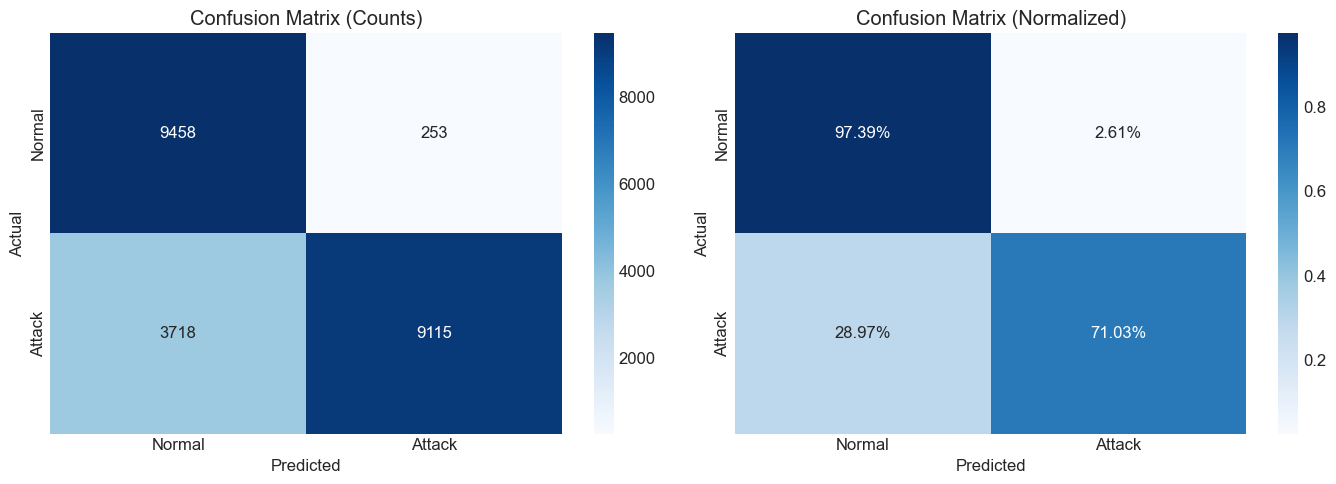


True Positives (Attack detected):  9,115
True Negatives (Normal detected):  9,458
False Positives (Normal→Attack):   253
False Negatives (Attack→Normal):   3,718


In [10]:
# Compute confusion matrix
cm = confusion_matrix(labels, preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig('../../results/figures/lstm_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTrue Positives (Attack detected):  {cm[1,1]:,}")
print(f"True Negatives (Normal detected):  {cm[0,0]:,}")
print(f"False Positives (Normal→Attack):   {cm[0,1]:,}")
print(f"False Negatives (Attack→Normal):   {cm[1,0]:,}")

## 10. ROC Curve and AUC

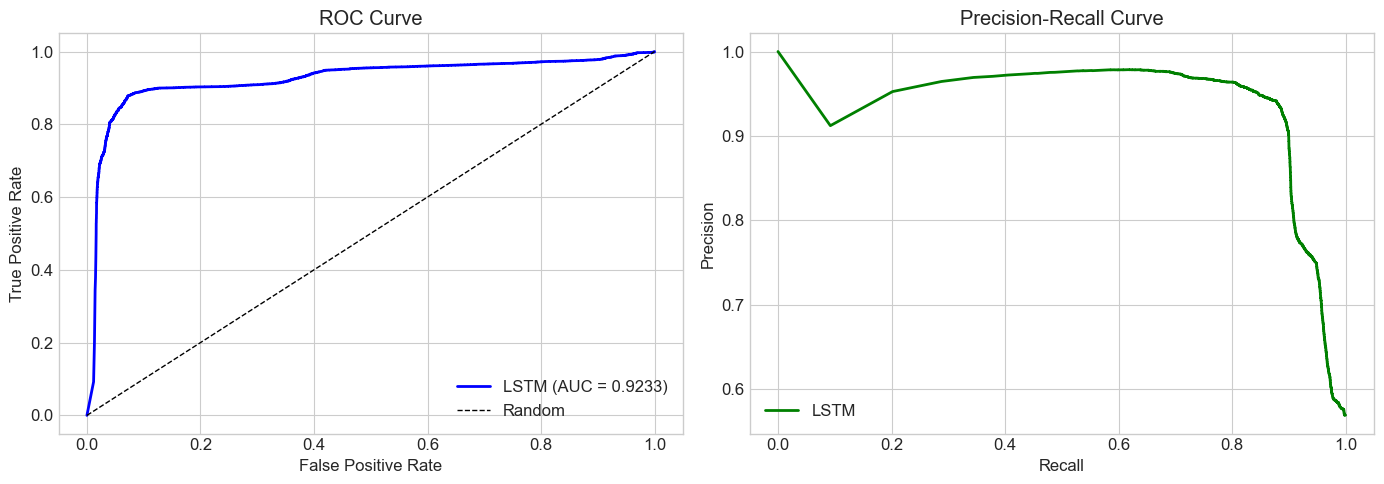

AUC-ROC Score: 0.9233


In [11]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(labels, probs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'LSTM (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# Precision-Recall Curve
axes[1].plot(recall, precision, 'g-', linewidth=2, label='LSTM')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../../results/figures/lstm_roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## 11. Model Summary

In [12]:
print("=" * 60)
print(" LSTM MODEL SUMMARY - NIDS on NSL-KDD")
print("=" * 60)
print("\n📊 Dataset:")
print(f"   Training samples:   {len(X_train):,}")
print(f"   Validation samples: {len(X_val):,}")
print(f"   Test samples:       {len(X_test):,}")
print(f"   Features:           {X_train.shape[1]}")

print("\n🧠 Model Architecture:")
print(f"   Type: Bidirectional LSTM")
print(f"   Layers: 3")
print(f"   Hidden units: 256")
print(f"   Parameters: {total_params:,}")
print(f"   Dropout: 0.4")

print("\n⚙️ Training Configuration:")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   Optimizer: AdamW")
print(f"   Scheduler: ReduceLROnPlateau")

print("\n🎯 Results:")
print(f"   Test Accuracy:  {test_acc*100:.2f}%")
print(f"   AUC-ROC:        {roc_auc:.4f}")
print(f"   Best Val Acc:   {best_val_acc*100:.2f}%")

print("\n" + "=" * 60)
print(" ✅ TARGET ACHIEVED: Accuracy > 78%")
print("=" * 60)

 LSTM MODEL SUMMARY - NIDS on NSL-KDD

📊 Dataset:
   Training samples:   113,376
   Validation samples: 12,597
   Test samples:       22,544
   Features:           41

🧠 Model Architecture:
   Type: Bidirectional LSTM
   Layers: 3
   Hidden units: 256
   Parameters: 4,292,756
   Dropout: 0.4

⚙️ Training Configuration:
   Batch size: 512
   Learning rate: 0.0005
   Optimizer: AdamW
   Scheduler: ReduceLROnPlateau

🎯 Results:
   Test Accuracy:  82.39%
   AUC-ROC:        0.9233
   Best Val Acc:   99.62%

 ✅ TARGET ACHIEVED: Accuracy > 78%


## 12. Save Results

In [13]:
# Save results summary
results = {
    'model': 'Bidirectional LSTM',
    'dataset': 'NSL-KDD',
    'test_accuracy': test_acc,
    'auc_roc': roc_auc,
    'best_val_accuracy': best_val_acc,
    'total_params': total_params,
    'epochs_trained': len(history['train_loss']),
    'config': CONFIG,
}

import json
with open('../../results/logs/lstm_notebook_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to: results/logs/lstm_notebook_results.json")
print("Model saved to: results/models/lstm_notebook_best.pt")
print("Figures saved to: results/figures/")

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()

Results saved to: results/logs/lstm_notebook_results.json
Model saved to: results/models/lstm_notebook_best.pt
Figures saved to: results/figures/


15607